# Comparison of MS partitions and NUTS over time

We compare the coverage of MS and NUTS at partition and community level over the course of the first UK lockdown.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import mercantile
from shapely.geometry import shape
import networkx as nx
import pickle
import scipy.sparse as sp
from scipy.optimize import least_squares
import datetime
from sklearn import metrics
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
from pathlib import Path
path = str(Path.cwd().parents[0])

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

from network_analysis import compute_indicator_matrix, compute_coverage, compute_coverage_community
from utils import R2_score
from response_model import select_model, return_response_parameters

root_figure = path+"/figures/"
root_map = path+'/data/geo_shapefiles/NUTS_Level_3__January_2018__Boundaries-shp/NUTS_Level_3__January_2018__Boundaries.shp'
root_processed = path+"/data/processed/"
root_networks = path+"/data/processed/networks/"
root_results = path+"/results/"

In [3]:
plt.rcParams.update({'font.size': 20})

## Import network data

In [4]:
# load baseline network
A_LSCC = sp.load_npz(root_networks+"baseline_network.npz")
lscc = nx.from_scipy_sparse_matrix(A_LSCC,create_using = nx.DiGraph)

# load node quadkeys
lscc_nodes = []
with open(root_networks+'node_quadkeys.txt', 'r') as filehandle:
    for line in filehandle:
        curr_quadkey = line[:-1]
        lscc_nodes.append(curr_quadkey)
n_nodes = len(lscc_nodes)

# Compute adjacency matrix and node list of LSCC
A_LSCC = nx.adjacency_matrix(lscc)
A_LSCC_array = A_LSCC.toarray()
lscc_nodes_list = np.asarray(list(lscc.nodes()))
s_lscc = len(lscc_nodes_list)

###########################
# Get dates of timeseries #
###########################

# Define start and end dates
start_date = "2020-03-10"
end_date = "2020-07-18"

# Generate DatetimeIndex
days = pd.date_range(start=start_date, end=end_date).date
n_days = len(days)
days_dm = np.asarray([str(days[i])[5:] for i in range(n_days)])
days_week = np.asarray(pd.date_range(start=start_date, end=end_date).weekofyear, dtype='int')
weeks = np.arange(days_week.min(),days_week.max())

# Indicate weekdays
weekday = pd.date_range(start=start_date, end=end_date).weekday<5

# Consider bank holidays
bank_holidays = []
bank_holidays.append(np.argwhere(days==datetime.date(2020, 4, 10))[0][0])
bank_holidays.append(np.argwhere(days==datetime.date(2020, 4, 13))[0][0])
bank_holidays.append(np.argwhere(days==datetime.date(2020, 5, 8))[0][0])
bank_holidays.append(np.argwhere(days==datetime.date(2020, 5, 25))[0][0])
weekday[bank_holidays] = False


# Store lockdown-date
lockdown_date = pd.to_datetime('20200324', format='%Y%m%d', errors='ignore')
lockdown_date_number = np.argwhere(days == lockdown_date).flatten()[0]
lockdown_week = lockdown_date.week

# Store date information
timestamps = {'days' : days, 'weekdays' : weekday, 'weeks' : weeks, 
              'lockdown_day' : lockdown_date}

In [5]:
# load adjacency matrices of daily networks
networks_adjacency = []

for i in range(n_days):
    date_str = str(days[i]).replace("-","_")
    networks_adjacency.append(sp.load_npz(root_networks+date_str+"_network.npz"))

## Compute daily number of trips

In [6]:
n_total = []
n_total_inter = []
n_total_intra = []
for A in networks_adjacency:
    intra = np.diag(np.diag(A.toarray()))
    B = A - intra
    n_total.append(np.sum(A))
    n_total_inter.append(np.sum(B))
    n_total_intra.append(np.sum(intra))
    
results = pd.DataFrame({'day':days, 'n_total': n_total, 
                        'n_total_inter' : n_total_inter, 
                        'n_total_intra':n_total_intra})

In [7]:
n_total_lscc = np.sum(A_LSCC)
intra_LSCC = np.diag(np.diag(A_LSCC.toarray()))
n_total_intra_lscc = np.sum(intra_LSCC)
B_LSCC = A_LSCC - intra_LSCC
n_total_inter_lscc = np.sum(B_LSCC)

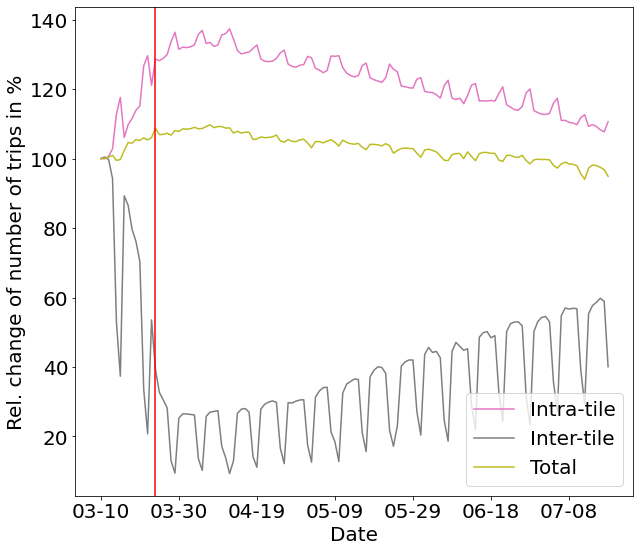

In [8]:
x_days = np.arange(n_days)
fig, ax = plt.subplots(1,figsize =(10,9))
ax.plot(100*results['n_total_intra']/results['n_total_intra'][0],label=r'Intra-tile',color='C6')
ax.plot(100*results['n_total_inter']/results['n_total_inter'][0],label=r'Inter-tile',color='C7')
ax.plot(100*results['n_total']/results['n_total'][0],label=r'Total',color = 'C8')

ax.axvline(x = lockdown_date_number, color = 'red')
ticks = range(0,n_days,20)
ax.set(xticks = ticks, xticklabels = days_dm[ticks], ylabel = 'Rel. change of number of trips in %',
      xlabel = 'Date')
      #,title='Number of trips over time')
ax.legend(loc=4,frameon = True)
plt.show()

fig.savefig(root_figure+'Number_Trips.pdf', dpi=fig.dpi,bbox_inches='tight')

## Load MS and NUTS partitions

In [9]:
# Load data (deserialize)
with open(root_results+'MS_results.pkl', 'rb') as handle:
    all_results = pickle.load(handle)
    
# Get times
times = all_results['times']
min_time = all_results['run_params']['min_time']
max_time = all_results['run_params']['max_time']
n_time = all_results['run_params']['n_time']
log_times = np.linspace(min_time,max_time,n_time)

# collect information for robust partitions
robust_scales = np.asarray([31, 97, 136, 162, 183, 202, 227, 247, 278])

ms_communities = np.zeros((len(robust_scales),n_nodes))

for i, scale in enumerate(robust_scales):
    ms_communities[i] = all_results['community_id'][scale]

ms_communities = np.asarray(ms_communities,dtype='int')

ms_times = log_times[robust_scales]

In [10]:
# Load NUTS3 data
root_NUTS3 = root_processed+'MOVEMENT_QUADKEY_NUTS3_GB.csv'
df_NUTS = pd.read_csv(root_NUTS3)
print('Shape of NUTS3 data:', df_NUTS.shape)

# Delete _ in front of quadkeys
quadkeys = [df_NUTS['quadkey'][i][1:] for i in range(df_NUTS.shape[0])]

# Get NUTS3 region names
NUTS3 = df_NUTS.columns.values.tolist()[1:]

# Get NUTS2 regions
to_NUTS2 = {NUTS3[i] : NUTS3[i][:4] for i in range(len(NUTS3))}
NUTS2_index = {list(to_NUTS2.values())[i] : i for i in range(len(to_NUTS2))}

# Get NUTS1 regions
to_NUTS1 = {NUTS3[i] : NUTS3[i][:3] for i in range(len(NUTS3))}
NUTS1_index = {list(to_NUTS1.values())[i] : i for i in range(len(to_NUTS1))}

# Compute for each quadkey NUTS3 region by max vote 
X = np.asarray(df_NUTS.iloc[:,1:])
max_rule = np.argmax(X,axis = 1)
print('The max is obtained in average with:',
      np.around(np.max(X,axis = 1).mean(),2) )

# Create dictionary from quadkeys to NUTS3 region id's
quadkey_NUTS3 = {quadkeys[i] : max_rule[i] for i in range(df_NUTS.shape[0])}

# Generate NUTS3 Id's for LSCC nodes
NUTS3_id = np.asarray([quadkey_NUTS3[lscc_nodes[i]] for i in range(n_nodes)])
print('NUTS3 communities in LSCC:', len(set(NUTS3_id)))

# Generate NUTS2 Id's
NUTS2_id = np.asarray([ NUTS2_index[to_NUTS2[NUTS3[NUTS3_id[i]]]] for i in range(n_nodes)])
print('NUTS2 communities in LSCC:', len(set(NUTS2_id)))

# Generate NUTS1 Id's
NUTS1_id = np.asarray([ NUTS1_index[to_NUTS1[NUTS3[NUTS3_id[i]]]] for i in range(n_nodes)])
print('NUTS1 communities in LSCC:', len(set(NUTS1_id)))

Shape of NUTS3 data: (3125, 180)
The max is obtained in average with: 0.92
NUTS3 communities in LSCC: 170
NUTS2 communities in LSCC: 42
NUTS1 communities in LSCC: 12


In [11]:
NUTS_partitions = []

for node_id in [NUTS3_id,NUTS2_id,NUTS1_id]:
    H = compute_indicator_matrix(node_id)
    # delete empty columns
    H = H[:, np.sum(H, axis=0) > 0]
    NUTS_partitions.append(H)

## Compute weekly networks

In [12]:
networks_week = []
networks_week_adjacency = []

for i in weeks:
    days_of_week = np.asarray(np.argwhere(days_week==i).flatten(),dtype = 'int')
    adjacency_week = networks_adjacency[days_of_week[0]:days_of_week[-1]+1]
    A = adjacency_week[0]
    for j in range(1,len(adjacency_week)):
        A+= adjacency_week[j]
    A /= len(adjacency_week)
    
    G = nx.DiGraph(A)
    networks_week.append(G)
    networks_week_adjacency.append(A)

n_weeks = len(networks_week)
networks = networks_week

In [13]:
len(weeks)

18

## Coverage

### a) absolute values

In [14]:
# Compute Coverage for MS partitions over timeseries
MS_Coverage = np.zeros((n_weeks,len(ms_times)))


for i in tqdm(range(n_weeks)):
    G = networks[i]
    for j, ms_time in enumerate(ms_times):
        partition = compute_indicator_matrix(ms_communities[j])
        MS_Coverage[i,j] = compute_coverage(G,partition,True)      

100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


In [15]:
# Compute Coverage for NUTS partitions over timeseries
NUTS_Coverage = np.zeros((n_weeks,3))

for i in tqdm(range(n_weeks)):
    G = networks[i]
    for j in range(3):
        partition = NUTS_partitions[j]
        NUTS_Coverage[i,j] = compute_coverage(G,partition,True)

100%|██████████| 18/18 [00:06<00:00,  2.62it/s]


In [16]:
ms_relevant_times = [0,1,3]

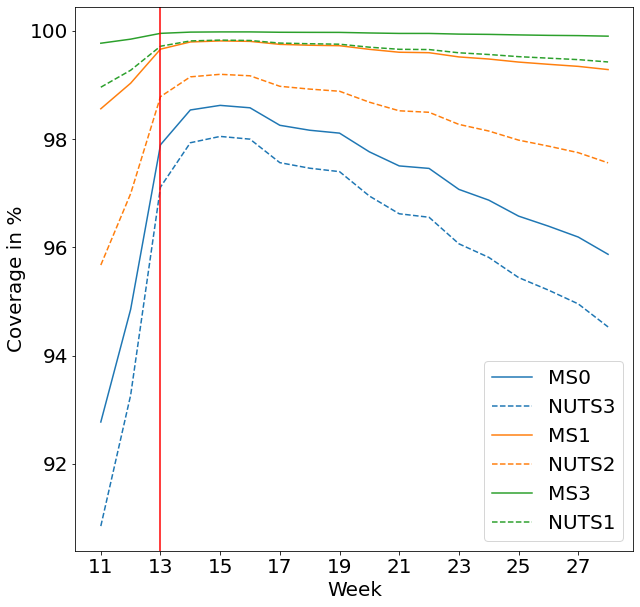

In [17]:
# Plot
fig, ax = plt.subplots(1,figsize =(10,10))
for i in range(3):
    ax.plot(weeks, 100*MS_Coverage[:,ms_relevant_times[i]],label = 'MS{}'.format(ms_relevant_times[i]), color = 'C'+str(i))
    ax.plot(weeks, 100*NUTS_Coverage[:,i],label = 'NUTS{}'.format(3-i), ls = '--', color = 'C'+str(i))
ax.axvline(x = lockdown_week, color = 'red')
ax.set(xticks = weeks[::2],ylabel = 'Coverage in %',xlabel='Week')
ax.legend()
plt.show()
#fig.savefig(root_figure+'days_fcoverage_total.pdf', dpi=fig.dpi,bbox_inches='tight')

### b) ratio of MS and NUTS

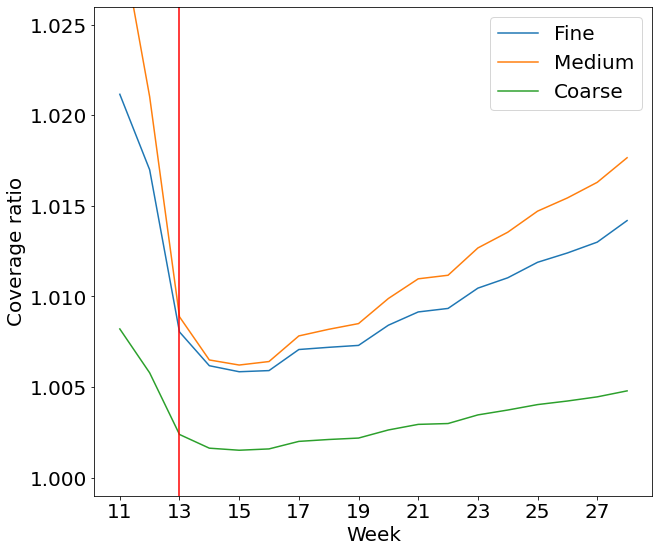

In [18]:
# Plot
fig, ax = plt.subplots(1,figsize =(10,9))
ax.plot(weeks,MS_Coverage[:,ms_relevant_times[0]]/NUTS_Coverage[:,0],label = 'Fine', color = 'C0')
ax.plot(weeks,MS_Coverage[:,ms_relevant_times[1]]/NUTS_Coverage[:,1],label = 'Medium', color = 'C1')
ax.plot(weeks,MS_Coverage[:,ms_relevant_times[2]]/NUTS_Coverage[:,2],label = 'Coarse', color = 'C2')
ax.axvline(x = lockdown_week, color = 'red')
ax.set(xticks = weeks[::2], xlabel = 'Week',ylabel = 'Coverage ratio', ylim = (0.999,1.026))
ax.legend()
fig.savefig(root_figure+'Coverage_ratio_WEEKLY.pdf', dpi=fig.dpi,bbox_inches='tight')
plt.show()

### c) response functions

Fine & 0.041822 (0.035504, 0.049732) & 16.4216 (12.4716, 21.4641) & 2.0189 (1.564, 2.6748) &  0 (-) & 100.0 & - & 0.039 & -201.4 & -198.8

Medium & 0.008609 (0.007385, 0.010124) & 18.7916 (14.581, 24.3305) & 1.9218 (1.5227, 2.4635) &  0 (-) & 100.0 & - & 0.017 & -262.2 & -259.6

Coarse & 0.001372 (0.001171, 0.001623) & 20.8744 (15.7184, 28.03) & 1.9794 (1.5536, 2.5677) &  0 (-) & 100.0 & - & 0.007 & -325.8 & -289.0



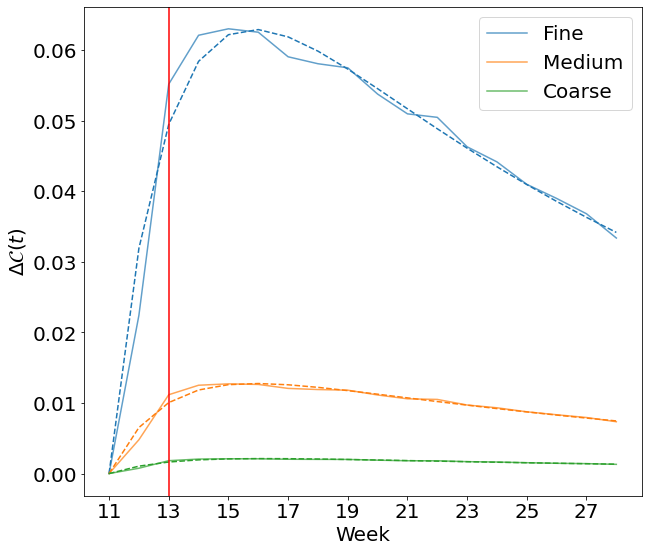

In [19]:
x_days = np.arange(n_weeks)

# Plot
fig, ax = plt.subplots(1,figsize =(10,9))
ax.set(xticks = weeks[::2], xlabel = 'Week',ylabel = r'$\Delta\mathcal{C}(t)$')
labels = ['Fine','Medium','Coarse']

for i in range(3):

    # Fit model to MS       
    ls = select_model(MS_Coverage[:,ms_relevant_times[i]],MS_Coverage[0,ms_relevant_times[i]], name=labels[i],use_window=False,use_m=False,decimals=4)

    # Plot MS
    ax.plot(weeks,MS_Coverage[:,ms_relevant_times[i]]/MS_Coverage[0,ms_relevant_times[i]]-1,color = 'C'+str(i),
            label = labels[i],alpha=0.7)
    ax.plot(weeks, ls.eval(ls.params, x=x_days)-1,color = 'C'+str(i), linestyle = '--')

ax.axvline(x = lockdown_week, color = 'red')
ax.legend(loc=1)
fig.savefig(root_figure+'Coverage_response_WEEKLY_FD.pdf', dpi=fig.dpi,bbox_inches='tight')
plt.show()

$s_1=-1.48$ & 0.041822 (0.0355036, 0.0497322) & 16.4216 (12.47155, 21.4641) & 2.0189 (1.56401, 2.67475) &  0 (-) & 100.0 & - & 0.039 & -201.4 & -198.8

$s_2=-0.38$ & 0.0086092 (0.0073855, 0.0101244) & 18.79157 (14.58102, 24.33048) & 1.92184 (1.52266, 2.46355) &  0 (-) & 100.0 & - & 0.017 & -262.2 & -259.6

$s_3=0.27$ & 0.0033662 (0.0028928, 0.0039519) & 21.80416 (16.80962, 28.70312) & 1.87443 (1.49452, 2.37867) &  0 (-) & 100.0 & - & 0.011 & -297.1 & -294.3

$s_4=0.71$ & 0.0013724 (0.0011714, 0.001623) & 20.87437 (15.71836, 28.03003) & 1.97945 (1.5536, 2.56769) &  0 (-) & 100.0 & - & 0.007 & -325.8 & -289.0

$s_5=1.06$ & 0.0008969 (0.0007659, 0.0010604) & 21.40514 (16.20768, 28.66014) & 1.93168 (1.52095, 2.49142) &  0 (-) & 100.0 & - & 0.006 & -342.1 & -305.3

$s_6=1.38$ & 0.0006265 (0.0005299, 0.0007482) & 18.77844 (13.84181, 25.48422) & 2.0734 (1.59517, 2.77091) &  0 (-) & 100.0 & - & 0.005 & -350.5 & -313.5

$s_7=1.8$ & 0.000478 (0.0004078, 0.0005657) & 20.87913 (15.64313, 28.16865)

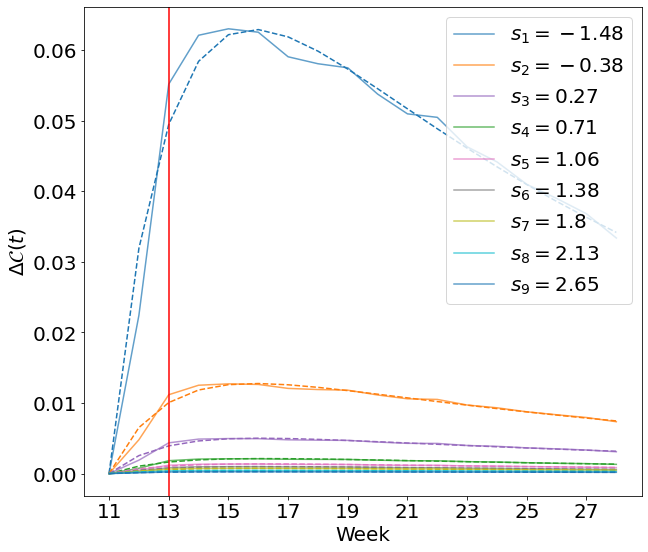

In [20]:
x_days = np.arange(n_weeks)

# Plot
fig, ax = plt.subplots(1,figsize =(10,9))
ax.set(xticks = weeks[::2], xlabel = 'Week',ylabel = r'$\Delta\mathcal{C}(t)$')

for i in range(len(robust_scales)):

    # Fit model to MS       
    ls = select_model(MS_Coverage[:,i],MS_Coverage[0,i], name=r'$s_{}={}$'.format(i+1,np.around(ms_times[i],2)),use_window=False,use_m=False,decimals=5)

    if i < 2:
        color = 'C'+str(i)
    if i == 2:
        color = 'C4'
    if i == 3:
        color = 'C2'
    if i > 3:
        color = 'C'+str(i+2)

    # Plot MS
    ax.plot(weeks,MS_Coverage[:,i]/MS_Coverage[0,i]-1,color = color,
            label = r'$s_{}={}$'.format(i+1,np.around(ms_times[i],2)),alpha=0.7)
    ax.plot(weeks, ls.eval(ls.params, x=x_days)-1,color = color, linestyle = '--')

ax.axvline(x = lockdown_week, color = 'red')
ax.legend(loc=1)
fig.savefig(root_figure+'Coverage_response_WEEKLY_FD_all_scales.pdf', dpi=fig.dpi,bbox_inches='tight')
plt.show()

## Response parameters for Coverage on community level

### a) Coverage at community level for MS0

In [21]:
n_communities = len(set(ms_communities[0]))
partition = compute_indicator_matrix(ms_communities[0])

Coverage_k_MS0 = np.zeros((n_weeks+1,n_communities))

# baseline
Coverage_k_MS0[0,:] = compute_coverage_community(lscc,partition,True)

# timeseries
for i in tqdm(range(n_weeks)):
    G = networks[i]
    Coverage_k_MS0[i+1,:] = compute_coverage_community(G,partition,True)

100%|██████████| 18/18 [05:07<00:00, 17.08s/it]


### b) fitting of response curves

In [22]:
partition = compute_indicator_matrix(ms_communities[0])
n_communities = len(set(ms_communities[0]))

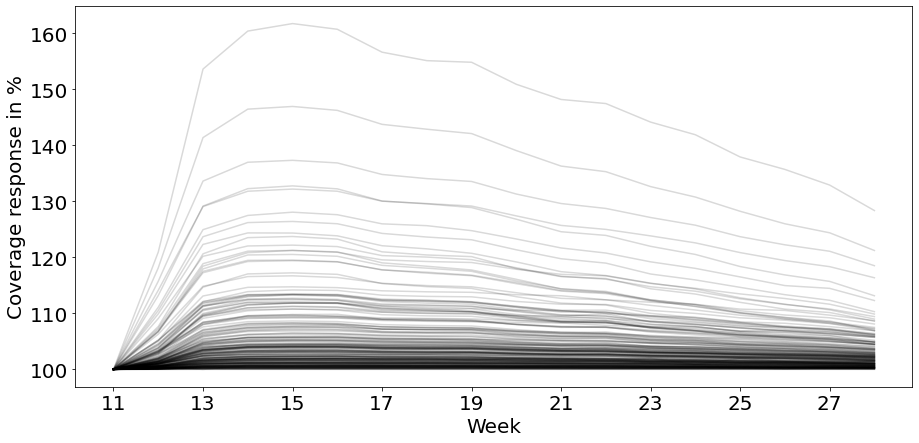

In [23]:
fig, ax = plt.subplots(1,figsize =(15,7))

ticks = range(0,n_weeks,2)

for j in range(n_communities):
    feature = Coverage_k_MS0[1:,j]
    base_value = Coverage_k_MS0[0,j]

    if np.isnan(feature).any():
        pass
    else:
        signal = np.asarray(feature / feature[0])
        ax.plot(weeks,100*signal,color = 'black', alpha=0.15)
    
ax.set(xticks = weeks[::2], xlabel = 'Week',ylabel = 'Coverage response in %')
    
    
plt.show()
    

In [24]:
base = np.zeros(n_communities)
alphas_Coverage = np.zeros(n_communities)
betas_Coverage = np.zeros(n_communities)
lambdas_Coverage= np.zeros(n_communities)
ms = np.zeros(n_communities)
lims = np.zeros(n_communities)
CVRMSEs = np.zeros(n_communities)

for j in tqdm(range(n_communities)):

    # Get baseline Coverage
    base_value = Coverage_k_MS0[0,j]

    # Get timeseries Coverage
    feature = Coverage_k_MS0[1:,j]
    
    if np.isnan(feature).any():

        # Add values
        base[j] = base_value
        alphas_Coverage[j] = np.NaN
        betas_Coverage[j] = np.NaN
        lambdas_Coverage[j] = np.NaN
        ms[j] = np.NaN
        lims[j] = np.NaN
        CVRMSEs[j] = np.NaN

    else:

        try:

            # Compute response parameters
            alpha, beta, lamb, m, lim, CVRMSE = return_response_parameters(feature,feature[0],use_window=False,use_m=False)
            
            # Add values
            base[j] = base_value
            alphas_Coverage[j] = alpha
            betas_Coverage[j] = beta
            lambdas_Coverage[j] = lamb
            ms[j] = m
            lims[j] = lim
            CVRMSEs[j] = CVRMSE

        except:

            base[j] = base_value
            alphas_Coverage[j] = np.NaN
            betas_Coverage[j] = np.NaN
            lambdas_Coverage[j] = np.NaN
            ms[j] = np.NaN
            lims[j] = np.NaN
            CVRMSEs[j] = np.NaN



100%|██████████| 201/201 [00:02<00:00, 87.54it/s] 


### c) response maps

In [25]:
import geopandas as gpd
import mercantile
from shapely.geometry import shape

In [26]:
# Import NUTS shape files
map_gdf = gpd.read_file(root_map)
map_gdf = map_gdf.to_crs("EPSG:3395")

# remove Scotish islands
map_gdf=map_gdf[~map_gdf['nuts318cd'].isin(['UKM65', 'UKM66'])]
map_gdf.reset_index(drop=True,inplace=True)

# Get NUTS3 
cols = [0,2,3,4,5,6,7,8]
gdf_NUTS3 = map_gdf.drop(map_gdf.columns[cols],axis=1)
gdf_NUTS3.rename(columns={'nuts318cd': 'nuts'}, inplace=True)

gdf_NUTS3['DUMMY'] = 1
gdf_bndr = gdf_NUTS3.dissolve(by = 'DUMMY')

In [27]:
# Get quadkeys from lscc
quadkeys = lscc_nodes
polys = []

# Iterate over all quadkeys to create corresponding polygons
for quadkey in quadkeys:
    tile = mercantile.feature(mercantile.quadkey_to_tile(quadkey), projected = 'web mercator')
    polys.append(tile.get('geometry'))
geom = [shape(i) for i in polys]
gdf = gpd.GeoDataFrame({'geometry':geom, 'quadkey':quadkeys}, crs = "EPSG:4326")
gdf = gdf.to_crs("EPSG:3395")

In [28]:
gdf['alpha_Coverage']= [alphas_Coverage[tile_comm] for tile_comm in ms_communities[0]]
gdf['beta_Coverage']= [betas_Coverage[tile_comm] for tile_comm in ms_communities[0]]
gdf['beta_inv_Coverage'] = 1/gdf['beta_Coverage']
gdf['is_nan_Coverage'] = [int(np.isnan(alphas_Coverage)[tile_comm])for tile_comm in ms_communities[0]]
gdf['lambda_Coverage'] = [lambdas_Coverage[tile_comm] for tile_comm in ms_communities[0]]
gdf['lambda_inv_Coverage'] = 1/gdf['lambda_Coverage']

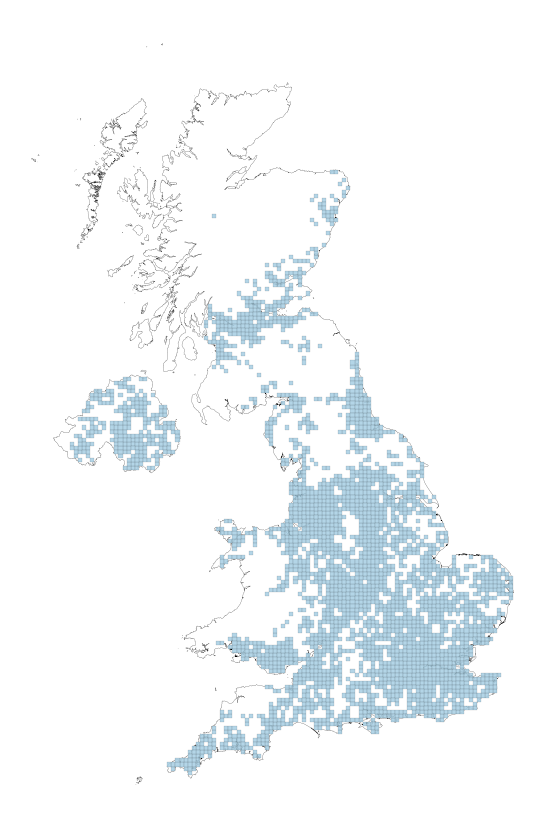

In [29]:
fig, ax = plt.subplots(1,figsize =(20,15))

tile_width = 0.1
map_width = 0.2

gdf_bndr.plot(linewidth=map_width, ax=ax, facecolor = 'none')
im = gdf.plot('is_nan_Coverage',alpha = 0.85, linewidth = tile_width,ax=ax, cmap='Paired',edgecolor='black')
ax.set_axis_off()

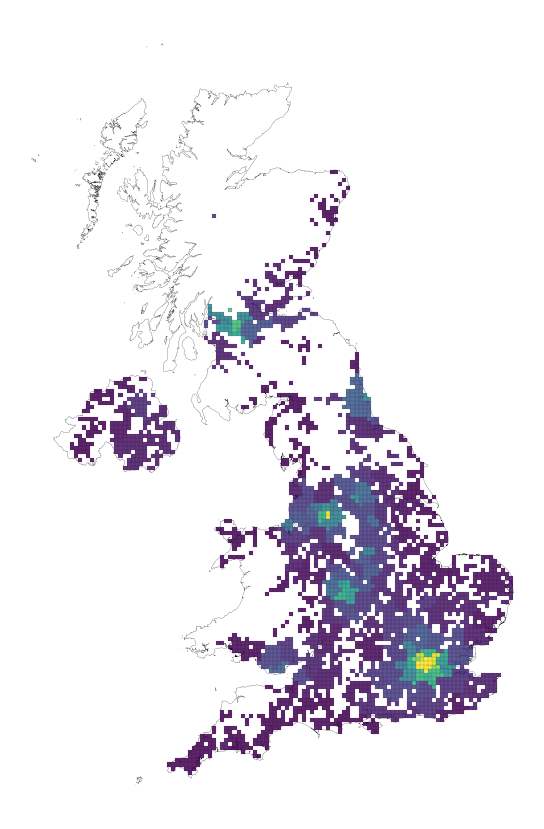

In [30]:
fig, ax = plt.subplots(1,figsize =(20,15))

tile_width = 0.1
map_width = 0.2

vmin_alpha_Coverage = np.percentile(alphas_Coverage[~np.isnan(alphas_Coverage)],5)
vmax_alpha_Coverage = np.percentile(alphas_Coverage[~np.isnan(alphas_Coverage)],95)

gdf_bndr.plot(linewidth=map_width, ax=ax, facecolor = 'none')
im = gdf.plot('alpha_Coverage',alpha = 0.85, linewidth = tile_width,ax=ax, #cmap='coolwarm',
vmin=vmin_alpha_Coverage,vmax=vmax_alpha_Coverage,edgecolor='black')
ax.set_axis_off()

fig.savefig(root_figure+'MS0_alphas_Coverage_WEEKLY_FD.pdf', dpi=fig.dpi,bbox_inches='tight')

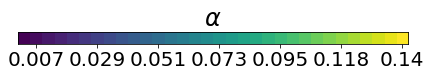

In [31]:
# Plot colourbar
n_steps = 32
fig, ax = plt.subplots(1, figsize=(7, 5))
ax.imshow(np.linspace(vmin_alpha_Coverage,vmax_alpha_Coverage,n_steps).reshape(1,n_steps))
ax.set(yticks=[],xticks = np.arange(0,n_steps,5)+1,
        xticklabels=np.around(np.asarray(np.linspace(vmin_alpha_Coverage,vmax_alpha_Coverage,n_steps)),3)[np.arange(0,n_steps,5)+1],
        title=r'$\alpha$')
plt.show()

fig.savefig(root_figure+'MS0_alphas_Coverage_WEEKLY_FD_legend.pdf', dpi=fig.dpi,bbox_inches='tight')

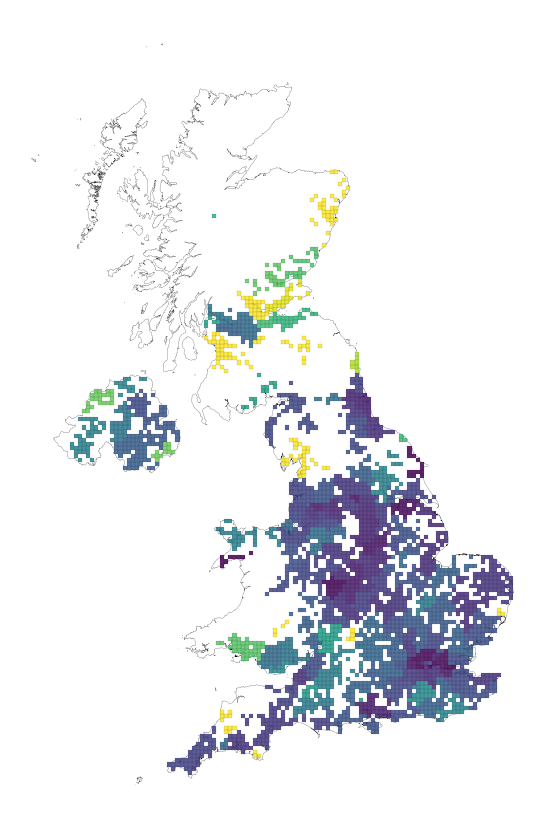

In [32]:
fig, ax = plt.subplots(1,figsize =(20,15))

tile_width = 0.1
map_width = 0.2

vmin_beta_inv_Coverage = np.percentile(1/betas_Coverage[~np.isnan(1/betas_Coverage)],5)
vmax_beta_inv_Coverage = np.percentile(1/betas_Coverage[~np.isnan(1/betas_Coverage)],95)

gdf_bndr.plot(linewidth=map_width, ax=ax, facecolor = 'none')
im = gdf.plot('beta_inv_Coverage',alpha = 0.85, linewidth = tile_width,ax=ax, #cmap='coolwarm',
vmin=vmin_beta_inv_Coverage,vmax=vmax_beta_inv_Coverage,edgecolor='black')
ax.set_axis_off()

fig.savefig(root_figure+'MS0_betas_inv_Coverage_FD_WEEKLY.pdf', dpi=fig.dpi,bbox_inches='tight')

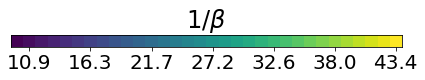

In [33]:
# Plot colourbar
n_steps = 32
fig, ax = plt.subplots(1, figsize=(7, 5))
ax.imshow(np.linspace(vmin_beta_inv_Coverage,vmax_beta_inv_Coverage,n_steps).reshape(1,n_steps))
ax.set(yticks=[],xticks = np.arange(0,n_steps,5)+1,
        xticklabels=np.around(np.asarray(np.linspace(vmin_beta_inv_Coverage,vmax_beta_inv_Coverage,n_steps)),1)[np.arange(0,n_steps,5)+1],
        title=r'$1/\beta$')
plt.show()

fig.savefig(root_figure+'MS0_betas_inv_Coverage_WEEKLY_FD_legend.pdf', dpi=fig.dpi,bbox_inches='tight')

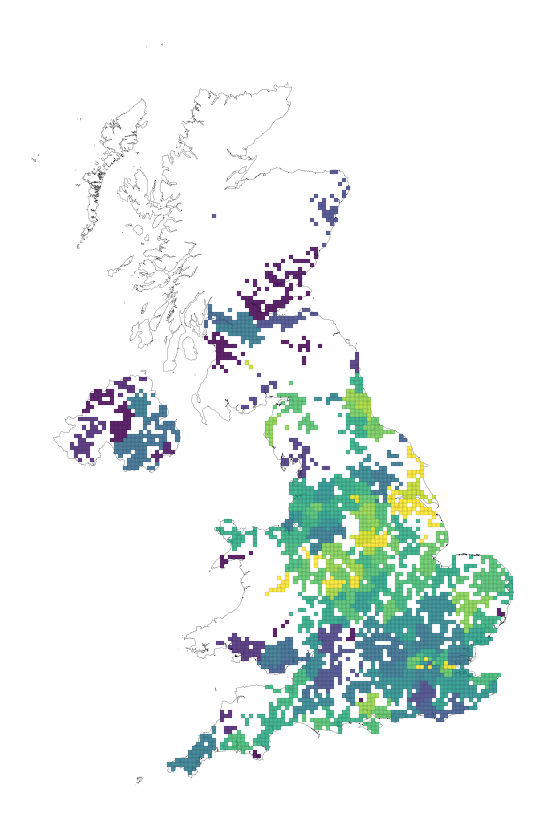

In [34]:
fig, ax = plt.subplots(1,figsize =(20,15))

tile_width = 0.1
map_width = 0.2

vmin_lambda_inv_Coverage = np.percentile(1/lambdas_Coverage[~np.isnan(1/lambdas_Coverage)],5)
vmax_lambda_inv_Coverage = np.percentile(1/lambdas_Coverage[~np.isnan(1/lambdas_Coverage)],95)

gdf_bndr.plot(linewidth=map_width, ax=ax, facecolor = 'none')
im = gdf.plot('lambda_inv_Coverage',alpha = 0.85, linewidth = tile_width,ax=ax, #cmap='coolwarm',
vmin=vmin_lambda_inv_Coverage,vmax=vmax_lambda_inv_Coverage, edgecolor='black')
ax.set_axis_off()

fig.savefig(root_figure+'MS0_lambdas_inv_Coverage_WEEKLY_FD.pdf', dpi=fig.dpi,bbox_inches='tight')

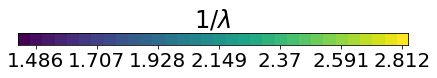

In [35]:
# Plot colourbar
n_steps = 32
fig, ax = plt.subplots(1, figsize=(7, 5))
ax.imshow(np.linspace(vmin_lambda_inv_Coverage,vmax_lambda_inv_Coverage,n_steps).reshape(1,n_steps))
ax.set(yticks=[],xticks = np.arange(0,n_steps,5)+1,
        xticklabels=np.around(np.asarray(np.linspace(vmin_lambda_inv_Coverage,vmax_lambda_inv_Coverage,n_steps)),3)[np.arange(0,n_steps,5)+1],
        title=r'$1/\lambda$')
plt.show()

fig.savefig(root_figure+'MS0_lambdas_inv_Coverage_WEEKLY_FD_legend.pdf', dpi=fig.dpi,bbox_inches='tight')